<a href="https://colab.research.google.com/github/AdarshKammar/Python/blob/main/pytorch_Human_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /tmp/pip-req-build-0i2wmw9w
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /tmp/pip-req-build-0i2wmw9w
  Resolved https://github.com/albumentations-team/albumentations to commit 9c41743e58f73404c28b5033de170a948bed638c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
print ("Cloning Dataset Reposotory...\n")
!git clone https://github.com/sindhurakshit/HumanSegNet.git
print ("Cloning Dataset Reposotory...\n")
print ("Downloading Dataset..\n")
print("Unziping dataset... \n")
!unzip  -oq	HumanSegNet/Human-Segmentation-Dataset.zip  # silent unzip
print("Unzip dataset completed.")

Cloning Dataset Reposotory...

fatal: destination path 'HumanSegNet' already exists and is not an empty directory.
Cloning Dataset Reposotory...


Unziping dataset... 

Unzip dataset completed.


In [3]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset')

In [4]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import torch


def show_image(image,mask,pred_image = None):

    if pred_image == None:

        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

    elif pred_image != None :

        f, (ax1, ax2,ax3) = plt.subplots(1, 3, figsize=(10,5))

        ax1.set_title('IMAGE')
        ax1.imshow(image.permute(1,2,0).squeeze(),cmap = 'gray')

        ax2.set_title('GROUND TRUTH')
        ax2.imshow(mask.permute(1,2,0).squeeze(),cmap = 'gray')

        ax3.set_title('MODEL OUTPUT')
        ax3.imshow(pred_image.permute(1,2,0).squeeze(),cmap = 'gray')

In [6]:
CSV_FILE='/content/Human-Segmentation-Dataset/train.csv'
DATA_DIR='/content/'
DEVICE = torch.device('cuda' if torch.cuda.is_available else 'cpu')
EPOCHS = 25
LR= 0.003
IMAGE_SIZE=320
BATCH_SIZE=16
ENCODER ='timm-efficientnet-b0'
WEIGHTS='imagenet'

In [7]:
#torch.set_default_device(DEVICE)
df = pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset/Ground_Truth/1.png,Human-Segmentation-Dataset/Training_Images/1.jpg
1,Human-Segmentation-Dataset/Ground_Truth/10.png,Human-Segmentation-Dataset/Training_Images/10.jpg
2,Human-Segmentation-Dataset/Ground_Truth/100.png,Human-Segmentation-Dataset/Training_Images/100...
3,Human-Segmentation-Dataset/Ground_Truth/101.png,Human-Segmentation-Dataset/Training_Images/101...
4,Human-Segmentation-Dataset/Ground_Truth/102.png,Human-Segmentation-Dataset/Training_Images/102...


In [8]:

index=4
row = df.iloc[index]
image_path=row.images
mask_path = row.masks

image= cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert BGR image read by cv2 to RGB

mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)/255.0

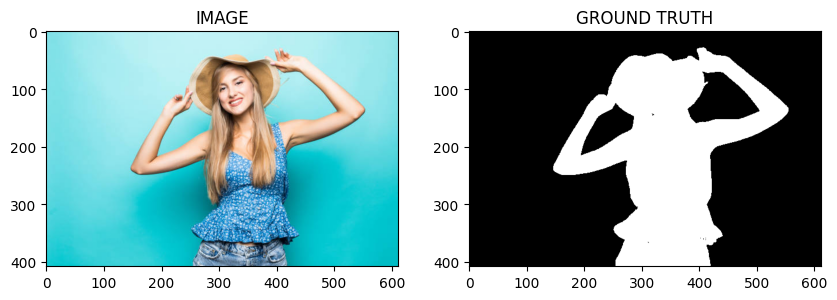

In [9]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))

ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [10]:
train_df, val_df = train_test_split(df, test_size=0.2)

In [11]:
import albumentations as A

In [12]:
def get_train_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),
                   A.HorizontalFlip(p=0.5),
                   A.VerticalFlip(p=0.5),],is_check_shapes=False) # is_check_shapes=False
def get_val_augs():
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),],is_check_shapes=False) #is_check_shapes=False

In [13]:
from torch.utils.data import Dataset


In [14]:
class PersonSegmentationDataset(Dataset):
  def __init__(self, df, augmentations):
    self.df=df
    self.augmentations=augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, index):
    row = df.iloc[index]
    image_path = row.images
    mask_path = row.masks

    image= cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # convert BGR image read by cv2 to RGB

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    #mask is in [ h, w] form add channel to it [h, w,c]
    mask = np.expand_dims(mask, axis=-1)

    # Apply albumentations is applicable
    if self.augmentations:
      data=self.augmentations(image=image, mask=mask)
      image = data['image']
      mask = data['mask']

    # convert  image and mask from [h,w,c]--> [c,h,w]
    image= np.transpose(image,(2,0,1))
    mask= np.transpose(mask,(2,0,1))

    # convert them to torch tensor and normalise

    image = torch.Tensor(image)/255.0
    mask = torch.Tensor(mask)/255.0

    return image, mask

In [15]:
trainset = PersonSegmentationDataset(train_df, get_train_augs())
validset = PersonSegmentationDataset(val_df, get_val_augs())



<ipython-input-12-6e3993ceed4f>:2: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),
<ipython-input-12-6e3993ceed4f>:6: UserWarning: Argument(s) 'always_apply' are not valid for transform Resize
  return A.Compose([A.Resize(IMAGE_SIZE, IMAGE_SIZE,always_apply=True,),],is_check_shapes=False) #is_check_shapes=False


In [16]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")


Size of Trainset : 232
Size of Validset : 58


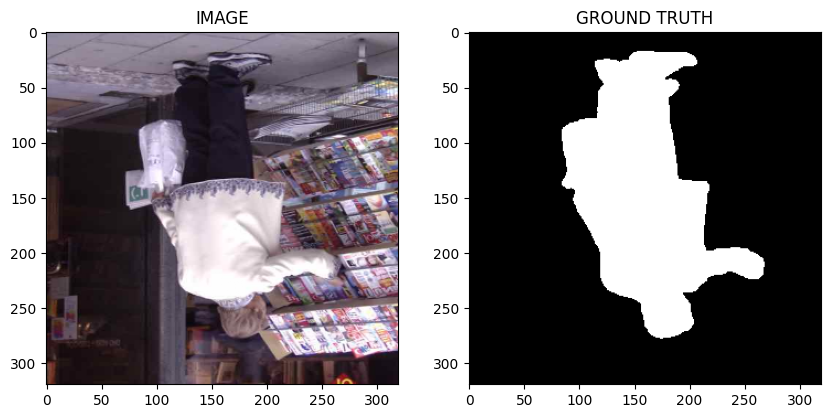

In [17]:
import torch  # Add this line

idx = 21
image, mask = trainset[idx]
show_image(image, mask)


In [18]:
from torch.utils.data import DataLoader

In [19]:
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
validloader =  DataLoader(validset,batch_size=BATCH_SIZE,)

#trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,generator=torch.Generator(device='cuda'))
#validloader =  DataLoader(validset,batch_size=BATCH_SIZE,generator=torch.Generator(device='cuda'))

In [20]:
print(f'Total number of batches in train loader : {len(trainloader)}')
print(f'Total number of batches in Valid loader : {len(validloader)}')

Total number of batches in train loader : 15
Total number of batches in Valid loader : 4


In [21]:
for image, mask in trainloader:
  break
print(f' One batch image shape {image.shape}')
print(f' One batch mask shape {mask.shape}')

 One batch image shape torch.Size([16, 3, 320, 320])
 One batch mask shape torch.Size([16, 1, 320, 320])


In [22]:
import torch.nn as nn
import segmentation_models_pytorch as smp
from segmentation_models_pytorch.losses import DiceLoss

In [23]:
class PersonSegmentationModel(nn.Module):
  def __init__(self):
    super(PersonSegmentationModel, self).__init__()
    self.arc = smp.Unet(encoder_name=ENCODER,
                        encoder_weights=WEIGHTS,
                        in_channels=3,
                        classes=1,
                        activation=None,
                        )
  def forward(self, images, masks=None):
    logits = self.arc(images)
    if masks!=None:
      loss1=DiceLoss(mode='binary')(logits, masks)
      loss2= nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1+loss2


In [24]:
model=PersonSegmentationModel()
model.to(DEVICE)

PersonSegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNormAct2d(
        32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): Swish()
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNormAct2d(
              32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): Swish()
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): 

In [25]:
def train_net(dataloader, model, optimizer):
  model.train()
  total_loss = 0.0
  for images, masks in tqdm(dataloader):
    images =images.to(DEVICE)
    masks = masks.to(DEVICE)
    optimizer.zero_grad()
    logits , loss = model(images, masks)
    loss.backward()
    optimizer.step()
    total_loss +=loss.item()
  return total_loss/len(dataloader)

In [26]:
def eval_net(dataloader, model):
  model.eval()
  total_loss = 0.0
  with torch.no_grad():
    for images, masks in tqdm(dataloader):
      images =images.to(DEVICE)
      masks = masks.to(DEVICE)
      logits , loss = model(images, masks)
      total_loss +=loss.item()
  return total_loss/len(dataloader)

In [27]:
optimizer=torch.optim.Adam(model.parameters(), lr=LR)

In [28]:
best_valid_loss=np.Inf
for i in range (EPOCHS):
  train_loss=train_net(trainloader, model, optimizer)
  valid_loss= eval_net(validloader, model)
  if valid_loss <best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("Model saved")
    best_valid_loss=valid_loss
  print(f'ECPOCH : {i+1} Training Loss : {train_loss}, Validation Loss : {valid_loss}')

100%|██████████| 4/4 [00:00<00:00,  4.70it/s]


Model saved
ECPOCH : 1 Training Loss : 0.7541540781656901, Validation Loss : 2.067152827978134


100%|██████████| 4/4 [00:00<00:00,  6.64it/s]


Model saved
ECPOCH : 2 Training Loss : 0.3262612521648407, Validation Loss : 1.101511761546135


100%|██████████| 4/4 [00:00<00:00,  6.62it/s]


Model saved
ECPOCH : 3 Training Loss : 0.365512345234553, Validation Loss : 0.20239104330539703


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


ECPOCH : 4 Training Loss : 0.2608168731133143, Validation Loss : 0.40602849051356316


100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


Model saved
ECPOCH : 5 Training Loss : 0.2483565737803777, Validation Loss : 0.18433227390050888


100%|██████████| 4/4 [00:00<00:00,  6.63it/s]


Model saved
ECPOCH : 6 Training Loss : 0.20797643462816875, Validation Loss : 0.14292199350893497


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


Model saved
ECPOCH : 7 Training Loss : 0.19858478208382924, Validation Loss : 0.1194300465285778


100%|██████████| 4/4 [00:00<00:00,  6.29it/s]


ECPOCH : 8 Training Loss : 0.2252468377351761, Validation Loss : 0.12148077227175236


100%|██████████| 4/4 [00:00<00:00,  6.82it/s]


Model saved
ECPOCH : 9 Training Loss : 0.18642190198103586, Validation Loss : 0.10729685239493847


100%|██████████| 4/4 [00:00<00:00,  5.52it/s]


Model saved
ECPOCH : 10 Training Loss : 0.15017218639453253, Validation Loss : 0.10230247676372528


100%|██████████| 4/4 [00:00<00:00,  6.70it/s]


Model saved
ECPOCH : 11 Training Loss : 0.13551389724016188, Validation Loss : 0.08854008466005325


100%|██████████| 4/4 [00:00<00:00,  5.37it/s]


ECPOCH : 12 Training Loss : 0.13121475825707118, Validation Loss : 0.09637271240353584


100%|██████████| 4/4 [00:00<00:00,  6.80it/s]


Model saved
ECPOCH : 13 Training Loss : 0.1399072935183843, Validation Loss : 0.0870317816734314


100%|██████████| 4/4 [00:00<00:00,  6.87it/s]


ECPOCH : 14 Training Loss : 0.16221669912338257, Validation Loss : 0.10516220889985561


100%|██████████| 4/4 [00:00<00:00,  6.85it/s]


ECPOCH : 15 Training Loss : 0.1914119447271029, Validation Loss : 0.20038460940122604


100%|██████████| 4/4 [00:00<00:00,  6.77it/s]


ECPOCH : 16 Training Loss : 0.17057167788346608, Validation Loss : 0.10359645821154118


100%|██████████| 4/4 [00:00<00:00,  6.95it/s]


ECPOCH : 17 Training Loss : 0.17008711248636246, Validation Loss : 0.09721401147544384


100%|██████████| 4/4 [00:00<00:00,  6.81it/s]


ECPOCH : 18 Training Loss : 0.1485696335633596, Validation Loss : 0.11225982941687107


100%|██████████| 4/4 [00:00<00:00,  6.92it/s]


ECPOCH : 19 Training Loss : 0.15247288395961126, Validation Loss : 0.09174913540482521


100%|██████████| 4/4 [00:00<00:00,  6.98it/s]


Model saved
ECPOCH : 20 Training Loss : 0.16044330199559528, Validation Loss : 0.08491857908666134


100%|██████████| 4/4 [00:00<00:00,  5.69it/s]


ECPOCH : 21 Training Loss : 0.13621177424987158, Validation Loss : 0.09777067601680756


100%|██████████| 4/4 [00:00<00:00,  6.96it/s]


ECPOCH : 22 Training Loss : 0.1344032754500707, Validation Loss : 0.11426472663879395


100%|██████████| 4/4 [00:00<00:00,  5.95it/s]


ECPOCH : 23 Training Loss : 0.1364976644515991, Validation Loss : 0.09218577295541763


100%|██████████| 4/4 [00:00<00:00,  6.93it/s]


ECPOCH : 24 Training Loss : 0.12476978699366252, Validation Loss : 0.09571214392781258


100%|██████████| 4/4 [00:00<00:00,  5.66it/s]


Model saved
ECPOCH : 25 Training Loss : 0.1133886456489563, Validation Loss : 0.07993096485733986


In [30]:
index=4
model.load_state_dict(torch.load('/content/best_model.pt'))
image, mask = validset[index]
logits_mask = model(image.to(DEVICE).unsqueeze(0))

<ipython-input-30-714160cfa1bb>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('/content/best_model.pt'))


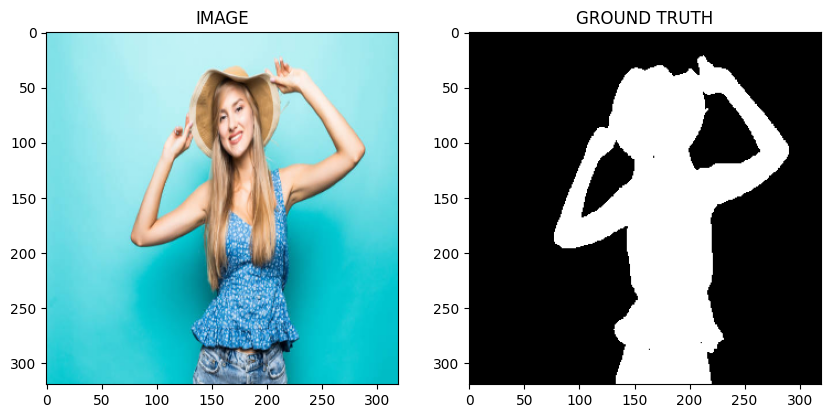

In [32]:
show_image(image, mask) # detach and remove batch info added earlier